# This file is used to train and test the model.

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
from sc_model import SC_LSTM as Model

# Device init

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    !nvidia-smi
    print(torch.cuda.get_device_name(0))

else:
    print("No GPU :(")

Tue Jul  4 05:04:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti      Off| 00000000:01:00.0  On |                  N/A |
| N/A   50C    P3               18W /  N/A|   1005MiB /  4096MiB |     21%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
device = 'cpu'

## Loading the data

In [4]:
from Data.Preprocessor import Preprocessor

preproc = Preprocessor()

data = pd.read_csv('../Data/schedule_v3.csv')
data

,Label Number,Duration,Importance,Start Time,Date
0,3,75,1,6:30,22/06/2023
1,5,90,2,8:15,22/06/2023
2,0,30,0,10:00,22/06/2023
3,1,30,1,10:45,22/06/2023
4,6,15,0,11:30,22/06/2023
...,...,...,...,...,...
967,4,90,2,18:15,01/09/2023
968,1,30,1,19:30,01/09/2023
969,6,45,0,20:45,01/09/2023
970,3,45,1,22:00,01/09/2023


In [5]:
input_data, type_vector, output_vector = preproc.preprocess(data)

In [6]:
input_data

,Label Number,Duration,Importance,Date,Time_Min,Time_Min_sin,Time_Min_cos,Date_Day_sin,Date_Day_cos,Date_Month_sin,Date_Month_cos
0,3,0.571429,1,173,0.265957,0.988948,-0.148264,-0.968077,-0.250653,-8.660254e-01,-0.5
1,5,0.714286,2,173,0.340426,0.818625,-0.574329,-0.968077,-0.250653,-8.660254e-01,-0.5
2,0,0.142857,0,173,0.414894,0.475947,-0.879474,-0.968077,-0.250653,-8.660254e-01,-0.5
3,1,0.142857,1,173,0.446809,0.293250,-0.956036,-0.968077,-0.250653,-8.660254e-01,-0.5
4,6,0.000000,0,173,0.478723,0.099046,-0.995083,-0.968077,-0.250653,-8.660254e-01,-0.5
...,...,...,...,...,...,...,...,...,...,...,...
967,4,0.714286,2,244,0.765957,-0.993309,0.115485,0.201299,0.979530,-2.449294e-16,1.0
968,1,0.142857,1,244,0.819149,-0.901991,0.431754,0.201299,0.979530,-2.449294e-16,1.0
969,6,0.285714,0,244,0.872340,-0.712928,0.701237,0.201299,0.979530,-2.449294e-16,1.0
970,3,0.285714,1,244,0.925532,-0.446609,0.894729,0.201299,0.979530,-2.449294e-16,1.0


In [7]:
type_vector

array(['resched', 'resched', 'non-resched', 'resched', 'resched',
       'resched', 'non-resched', 'resched', 'resched', 'resched',
       'resched', 'resched', 'resched', 'non-resched', 'non-resched',
       'resched', 'resched', 'non-resched', 'resched', 'resched',
       'resched', 'resched', 'non-resched', 'resched', 'resched',
       'resched', 'resched', 'resched', 'resched', 'resched',
       'non-resched', 'resched', 'resched', 'non-resched', 'resched',
       'non-resched', 'non-resched', 'resched', 'non-resched',
       'non-resched', 'resched', 'resched', 'resched', 'resched',
       'resched', 'non-resched', 'non-resched', 'resched', 'resched',
       'resched', 'non-resched', 'non-resched', 'resched', 'non-resched',
       'non-resched', 'resched', 'resched', 'resched', 'non-resched',
       'resched', 'resched', 'resched', 'non-resched', 'non-resched',
       'resched', 'resched', 'resched', 'resched', 'non-resched',
       'resched', 'resched', 'resched', 'resched', 'non

In [8]:
output_vector

,start,end,refr
0,390,75,0
1,495,90,0
2,600,30,0
3,645,30,0
4,690,15,0
...,...,...,...
967,1095,90,0
968,1170,30,0
969,1245,45,0
970,1320,60,15


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Normalize input and output data
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)
output_vector = scaler.fit_transform(output_vector)

## Creating the dataset

In [10]:
from torch.utils.data import Dataset, DataLoader2

class ScheduleDataset(Dataset):
    def __init__(self, input_data, type_vector, output_vector, task_types='all', transform=None):
        if task_types == 'all':
            self.input_data = input_data
            self.type_vector = type_vector
            self.output_vector = output_vector
        elif task_types == 'resched':
            self.input_data = []
            self.type_vector = []
            self.output_vector = []
            for i in range(len(input_data)):
                if type_vector[i] == "resched":
                    self.input_data.append(input_data[i])
                    self.type_vector.append(type_vector[i])
                    self.output_vector.append(output_vector[i])
        elif task_types == 'non-resched':
            self.input_data = []
            self.type_vector = []
            self.output_vector = []
            for i in range(len(input_data)):
                if type_vector[i] == "non-resched":
                    self.input_data.append(input_data[i])
                    self.type_vector.append(type_vector[i])
                    self.output_vector.append(output_vector[i])
        else:
            raise ValueError("task_types must be 'all', 'resched', or 'non-resched'")
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.type_vector[idx], self.output_vector[idx]


In [11]:
resched_dataset = ScheduleDataset(input_data, type_vector, output_vector, task_types='resched')
non_resched_dataset = ScheduleDataset(input_data, type_vector, output_vector, task_types='non-resched')
all_dataset = ScheduleDataset(input_data, type_vector, output_vector, task_types='all')

print(f"Resched dataset size: {len(resched_dataset)}\n"
      f"Non-resched dataset size: {len(non_resched_dataset)}\n"
      f"All dataset size: {len(all_dataset)}")

Resched dataset size: 776
Non-resched dataset size: 196
All dataset size: 972


## Create dataloaders

In [12]:
batch_size = 1
# resched_dataset_size = len(resched_dataset)
# train_size = int(resched_dataset_size * 0.8)
# test_size = resched_dataset_size - train_size
#
# train_resched_dataset, test_resched_dataset = torch.utils.data.random_split(resched_dataset, [train_size, test_size])

train_resched_dataloader = DataLoader2(resched_dataset, batch_size=batch_size)
# valid_resched_dataloader = DataLoader2(resched_dataset, batch_size=batch_size)

train_non_resched_dataloader = DataLoader2(non_resched_dataset, batch_size=batch_size)

## Create free time slots generator

In [13]:
from Data.GeneratorOfAvailableTimeslots import GeneratorOfAvailableTimeslots

time_slots_gen = GeneratorOfAvailableTimeslots(5)
time_slots = time_slots_gen.generate_available_timeslots()

time_slots      # TODO: why all the intervals are closed?
single_interval = time_slots[0]
single_interval

array([[0.        , 0.91437718],
       [0.91437718, 0.95310873],
       [0.95310873, 0.96994584],
       [0.96994584, 0.98506816],
       [0.98506816, 0.99220433],
       [0.99220433, 0.99452314],
       [0.99452314, 0.99694182],
       [0.99694182, 0.99984784],
       [0.99984784, 0.99997818]])

## Init the model

In [14]:
# check if the dataloader works and get the input and output sizes
in_features = 0
out_features = 0
for i, (features, a, ans) in enumerate(train_resched_dataloader):
    in_features = features.shape[1]
    out_features = ans.shape[1]
    break

n_layers = 2
hidden_size = 124
hidden_injector = 64

# Create the model
SC_LSTM = Model(in_features, n_layers, hidden_size, out_features, batch_size, hidden_injector=hidden_injector).to(device)

# Testing the model

In [15]:
# Configure hyper-parameters
epochs = 20
learning_rate = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SC_LSTM.parameters(), lr=learning_rate)

history = []
loss_accomulator = []
mean_loss = None

In [16]:
# Firstly train the LSTM using only reschedulable tasks
SC_LSTM.train()
SC_LSTM.train_lstm()

for epoch in range(0, epochs):
    SC_LSTM.reset_states()
    for i, (X, task_type, Y) in enumerate(tqdm(train_resched_dataloader, desc=f"Epoch: {epoch + 1}, Mean Loss: {mean_loss}", leave=False, colour='green')):

        # Convert X and Y to the correct type
        X = torch.Tensor(X).type(torch.float32).to(device)
        Y = torch.Tensor(Y).type(torch.float32).to(device)

        # Make prediction
        Y_pred = SC_LSTM.forward(X, task_type=task_type, free_time_slots=single_interval, save_states=True)

        # Calculate loss
        loss = loss_func(Y_pred.view(-1, ), Y.view(-1, ))

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append loss to list
        loss_accomulator.append(loss.item())

    mean_loss = np.mean(loss_accomulator)
    history.append(mean_loss)
    loss_accomulator = []

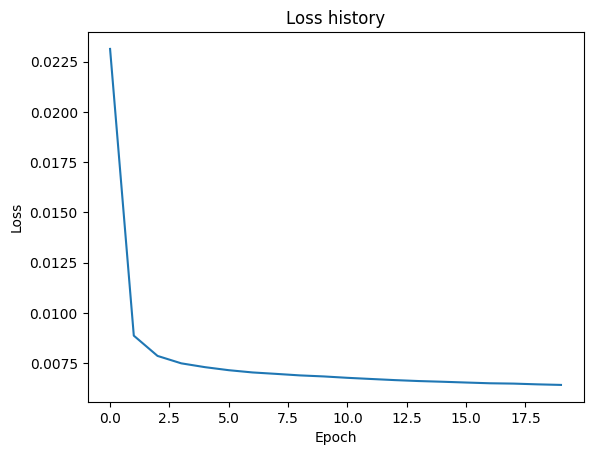

In [17]:
import matplotlib.pyplot as plt
# Plot the loss history
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.show()

In [18]:
# Configure hyper-parameters
epochs = 20
learning_rate = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SC_LSTM.parameters(), lr=learning_rate)

history = []
loss_accomulator = []

In [19]:
# Now train the injector using non-reschedulable tasks
SC_LSTM.train()
SC_LSTM.train_injector()

for epoch in range(0, epochs):
    SC_LSTM.reset_states()

    for i, (X, task_type, Y) in enumerate(tqdm(train_non_resched_dataloader, desc=f"Epoch: {epoch + 1}, Mean Loss: {mean_loss}", leave=False, colour='green')):

        # Convert X and Y to the correct type
        X = torch.Tensor(X).type(torch.float32).to(device)
        Y = torch.Tensor(Y).type(torch.float32).to(device)

        # Make prediction
        Y_pred = SC_LSTM.forward(X, task_type=task_type, free_time_slots=single_interval, save_states=True)

        # Calculate loss
        loss = loss_func(Y_pred.view(-1, ), Y.view(-1, ))

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append loss to list
        loss_accomulator.append(loss.item())

    mean_loss = np.mean(loss_accomulator)
    history.append(mean_loss)
    loss_accomulator = []

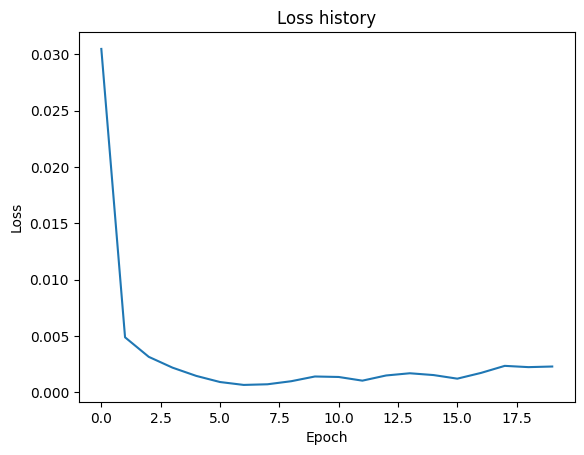

In [20]:
# Plot the loss history
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.show()